In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

warnings.filterwarnings("ignore")

# Constants
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

TARGET_COLUMNS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
TARGET_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5], device=DEVICE)

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
# Load and Pivot Data
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
df = df.pivot_table(index="image_path", columns="target_name", values="target").reset_index()
df.fillna(0, inplace=True)

class BiomassDataset(Dataset):
    def __init__(self, dataframe, transform=None, scaler=None):
        self.df = dataframe
        self.transform = transform
        self.scaler = scaler
        # The base path where the 'train' and 'test' folders are located
        self.base_dir = "/kaggle/input/csiro-biomass"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get the relative path from the dataframe (e.g., 'train/ID101...jpg')
        relative_path = self.df.iloc[idx]['image_path']
        
        # 2. Join it with the correct base directory
        # This results in: /kaggle/input/csiro-biomass/train/ID101...jpg
        img_path = os.path.join(self.base_dir, relative_path)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            # Fallback check: if the path structure is slightly different on some OS
            print(f"Error loading: {img_path}")
            raise

        if self.transform:
            image = self.transform(image)
            
        targets = self.df.iloc[idx][TARGET_COLUMNS].values.astype(np.float32)
        if self.scaler:
            targets = self.scaler.transform(targets.reshape(1, -1)).flatten()
            
        return image, torch.tensor(targets, dtype=torch.float32)
        
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdims=True)
    ss_res = ((y_true - y_pred) ** 2).sum(0)
    ss_tot = ((y_true - mean_y) ** 2).sum(0)
    r2_per_target = 1 - (ss_res / (ss_tot + 1e-8))
    weighted_r2 = (r2_per_target * weights).sum()
    return weighted_r2

def extract_features(model, loader):
    model.eval()
    features, targets = [], []
    with torch.no_grad():
        for imgs, targs in tqdm(loader, leave=False):
            imgs = imgs.to(DEVICE)
            # Standard CLS token extraction
            output = model(imgs)
            features.append(output.cpu().numpy())
            targets.append(targs.numpy())
    return np.vstack(features), np.vstack(targets)

In [4]:
model_variants = {
    'ViT-S': 'dinov2_vits14',
    'ViT-B': 'dinov2_vitb14',
    'ViT-L': 'dinov2_vitl14'
}

comparison_stats = {}

for name, repo_key in model_variants.items():
    print(f"\n--- Testing Variant: {name} ---")
    
    # Load Backbone
    backbone = torch.hub.load('facebookresearch/dinov2', repo_key).to(DEVICE)
    backbone.eval()
    
    # Prepare Dataloader (no augmentation for pure feature extraction)
    extract_ds = BiomassDataset(df, val_transforms)
    extract_loader = DataLoader(extract_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    # 1. Extract Features
    X_all, y_all = extract_features(backbone, extract_loader)
    
    # 2. 5-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_all)):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]
        
        # Target Scaling per fold
        scaler = StandardScaler().fit(y_train)
        y_train_scaled = scaler.transform(y_train)
        
        # Train CatBoost
        cat = MultiOutputRegressor(CatBoostRegressor(
            iterations=1000, 
            learning_rate=0.05, 
            depth=6, 
            task_type='GPU' if torch.cuda.is_available() else 'CPU', 
            silent=True
        ))
        
        cat.fit(X_train, y_train_scaled)
        
        # Predict and Inverse Scale
        preds_scaled = cat.predict(X_val)
        y_pred = np.maximum(scaler.inverse_transform(preds_scaled), 0)
        
        score = weighted_r2_score(y_val, y_pred, TARGET_WEIGHTS.cpu().numpy())
        fold_scores.append(score)
        print(f"Fold {fold+1} R2: {score:.4f}")
        
    comparison_stats[name] = {
        'Mean R2': np.mean(fold_scores),
        'Std Dev': np.std(fold_scores)
    }
    
    # Cleanup memory before next model
    del backbone
    torch.cuda.empty_cache()

# 3. Final Summary Table
summary_df = pd.DataFrame(comparison_stats).T
print("\n=== COMPARISON SUMMARY ===")
print(summary_df)


--- Testing Variant: ViT-S ---
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 297MB/s]


Fold 1 R2: 0.4629
Fold 2 R2: 0.5751
Fold 3 R2: 0.6487
Fold 4 R2: 0.5853
Fold 5 R2: 0.4793

--- Testing Variant: ViT-B ---


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 311MB/s]  


Fold 1 R2: 0.5424
Fold 2 R2: 0.6086
Fold 3 R2: 0.6294
Fold 4 R2: 0.6024
Fold 5 R2: 0.4638

--- Testing Variant: ViT-L ---


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth


100%|██████████| 1.13G/1.13G [00:03<00:00, 349MB/s]


Fold 1 R2: 0.5855
Fold 2 R2: 0.5715
Fold 3 R2: 0.6656
Fold 4 R2: 0.5806
Fold 5 R2: 0.3594

=== COMPARISON SUMMARY ===
        Mean R2   Std Dev
ViT-S  0.550276  0.069572
ViT-B  0.569319  0.060178
ViT-L  0.552516  0.102299


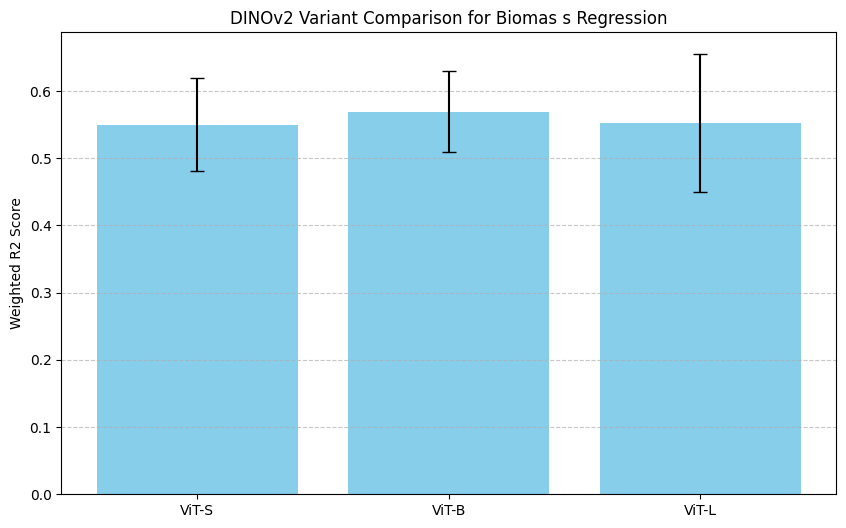

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(summary_df.index, summary_df['Mean R2'], yerr=summary_df['Std Dev'], capsize=5, color='skyblue')
plt.ylabel('Weighted R2 Score')
plt.title('DINOv2 Variant Comparison for Biomas s Regression')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()